In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from scipy.spatial.distance import pdist


import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'slibkind':
    p = '/Users/slibkind/Documents/'

net = 'binary_inputs'
PATH_YANGNET = os.path.join(p,'code/sophie-nets',net) 
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools


from teaspoon.TDA.Draw import drawDgm
from teaspoon.TDA.BuZZ import PtClouds
import dionysus


In [2]:
#WHERE IS THE NETWORK
rnn_type = 'LeakyRNN' 
activation = 'softplus'
w_init = 'randgauss'
ruleset = 'basic' # what set of tasks (look up in task.py)
n_rnn = str(256)
l2w = -7.0        # exponent of regularization terms
l2h = -7.0
l1w = 0
l1h = 0
lr = -7.0   # learning rate
seed = str(0)
rule_trains = [rules_dict['basic'][1],rules_dict['basic'][3]] # what rules to train on
rule_trains_str = '_'.join(rule_trains)
sigma_rec = 1/20
sigma_x = 2/20
w_rec_coeff = .9

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

dir_specific_all = os.path.join(ruleset,rnn_type,activation,
    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2)

m = os.path.join(p,'data','sophie-nets',net,'data',dir_specific_all,str(seed))


In [3]:
with open(os.path.join(m,'hparams.pkl'), 'rb') as f:
    hparams = pickle.load(f)

with open(os.path.join(m,'params.pkl'), 'rb') as f:
    params = pickle.load(f)

In [4]:
n_input = hparams['n_input']
n_rnn = hparams['n_rnn']
n_output = hparams['n_output']
w_in = params[0]  # [input weights , recurrent weights] 7+256, 256
b_in = params[1]
w_out = params[2]
b_out = params[3]
sigma_rec = hparams['sigma_rec']
dt = hparams['dt']
tau = hparams['tau']
alpha = dt/tau
activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

In [5]:
def get_interp_filename(ri_set, epoch_list, t_set):
  rule1, rule2 = np.array(rules_dict[ruleset])[ri_set]
  filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(t_set[0])+'_x'+str(t_set[1])
  return filename


"""
Gets the fp_struct for the fixed points with the specified inputs.
The specification specifies the dynamics at step_i
  interpolated between the inputs at ri_set | epoch_list | trial_num
"""
def get_fp_struct(ri_set, epoch_list, trial_num, step_i, 
              q_thresh = 1e-6,
              step_file = 'interp_tasks_small_init_stim'):
    q_tol_name = 'tol_q_e_6.0'
    f = get_interp_filename(ri_set, epoch_list, trial_num)    
    tasks_str = '_'.join([rules_dict[ruleset][ri_set[0]],rules_dict[ruleset][ri_set[1]]])
    save_dir = os.path.join(m,step_file,tasks_str)
    fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
    return fp_struct 

"""
Gets the indices of the fixed points below a particular threshold
"""
def get_fps_below_qthresh_idx(ri_set, epoch_list, trial_num, step_i, 
              q_thresh = 1e-6,
              step_file = 'interp_tasks_small_init_stim'):

  
  fp_struct = get_fp_struct(ri_set, epoch_list, trial_num, step_i, q_thresh, step_file)

  return  np.where(fp_struct['qstar'] < q_thresh)[0] # get indices of fixed points which have qstart below the threshold

"""
Gets the values of the fixed points below a certain threshold
"""
def get_xstar(ri_set, epoch_list, trial_num, step_i, 
              q_thresh = 1e-6,
              step_file = 'interp_tasks_small_init_stim',
              att_only = False):

  fp_struct = get_fp_struct(ri_set, epoch_list, trial_num, step_i, q_thresh, step_file)
  qindices = get_fps_below_qthresh_idx(ri_set, epoch_list, trial_num, step_i, q_thresh, step_file)

  if att_only:
    indices = []
    eigs = np.linalg.eigvals(fp_struct['J_xstar'])
    for i in qindices:
      if np.abs(np.max(eigs[i])) < .99:
        indices.append(i)
  else:
    indices = qindices
  return fp_struct['xstar'][indices]

"""
Gets the eigenvalues of the Jacobian at the fixed poitns below a certain threshold.
"""
def get_eigenvals(ri_set, epoch_list, trial_num, step_i, 
              q_thresh = 1e-6,
              step_file = 'interp_tasks_small_init_stim'):
  fp_struct = get_fp_struct(ri_set, epoch_list, trial_num, step_i, q_thresh, step_file)
  indices = get_fps_below_qthresh_idx(ri_set, epoch_list, trial_num, step_i, q_thresh, step_file)
  
  J_xstar = fp_struct['J_xstar'][indices]
  return np.linalg.eigvals(J_xstar)


In [6]:
"""
Run the vanilla RNN from initial condition h0 and with input given 
by the step_i interpolated step between the tasks specified by 
ri_set | epoch_list | trial num

"""
def vanilla_run_interp(h0, ri_set, epoch_list, trial_num, step_i,
                       iters = 1000):

  # generate trials in order to get the inputs
  rule1 = rules_dict[ruleset][ri_set[0]]
  trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
  rule2 = rules_dict[ruleset][ri_set[1]]
  trial2 = gen_trials_from_model_dir(m, rule2, mode = 'test', noise_on = False)
  
  # figure out the "difference" between the two inputs so that we can interopolate
  T_inds1 = get_T_inds(trial1,epoch_list[0])
  inputs_1 = np.max(trial1.x[T_inds1, trial_num[0], :], axis = 0)

  T_inds2 = get_T_inds(trial2,epoch_list[1])
  inputs_1 = np.max(trial1.x[T_inds2, trial_num[1], :], axis = 0)
  
  del_inputs = inputs_2 - inputs_1

  # get the proper interpolation of inputs
  x = inputs_1+del_inputs*(step_i/n_interp) # this interpolates the inputs between the two trials

  # run the network with the interpolated inputs and
  #     initial condition fixed to be the initial condition of the first task

  ht = np.zeros(shape = (iters, int(n_rnn)))
  ht[0] = h0
  for i in range(iters-1):
    ht[i+1] = rnn_vanilla(params, ht[i], x, hparams['dt']/hparams['tau'])

  return ht

In [7]:
def get_epoch_label(ri, epoch, trial):
  return "|".join([rules_dict[ruleset][ri], epoch, "stimulus " + str(trial+1)])

def get_epoch_labels(ri_set, epoch_list, trial_num):
  return [get_epoch_label(ri_set[i], epoch_list[i], trial_num[i]) for i in range(len(ri_set))]

def get_ZZ_filename(ri_set, epoch_list, trial_num, q_thresh, n_interp, step, radius):
  epoch_labels = get_epoch_labels(ri_set, epoch_list, trial_num)
  path = os.path.join(m, 'ZigZag','_'.join(epoch_labels) ,str(q_thresh), str(n_interp)+'_'+str(step))
  if not os.path.exists(path):
    print(path)
    os.makedirs(path)
  return os.path.join(path, 'radius_'+str(radius)+'.pkl' )

In [8]:
# a list where each entry is the a point cloud with shape (n, 256) where n is the number of points

"""
returns (ptcloud_list, idx)
ptcloud_list is a list of point clouds for each step along a series of interpolated tasks
idx is a list of indices where you will find the point cloud for the pure tasks
"""

def get_ptcloud_list(ri_set, epoch_list, trial_num, q_thresh, n_interp, step_size):

  ptcloud_list = []
  idx = []
  i = 0
  for ti in range(len(ri_set) - 1):
    idx.append(i)
    for step_i in range(0, n_interp, step_size):
      fps = get_xstar(ri_set[ti:ti+2], epoch_list[ti:ti+2], trial_num[ti:ti+2], step_i, q_thresh = q_thresh, att_only = True)
      ptcloud_list.append(fps) 
      i += 1   
  
  # add the final one
  fps = get_xstar(ri_set[ti:ti+2], epoch_list[ti:ti+2], trial_num[ti:ti+2], n_interp, q_thresh = q_thresh, att_only = True)
  ptcloud_list.append(fps)
  idx.append(i)

  return ptcloud_list, idx
  

In [17]:
ri_set = [1,1,3,3]
epoch_list = ['stim1', 'delay1', 'delay1', 'stim1']
trial_num = [0,0,1,1]
q_thresh = 1e-6
n_interp = 20
step_size = 2

ptcloud_list, task_idx = get_ptcloud_list(ri_set, epoch_list, trial_num, q_thresh, n_interp, step_size)

In [18]:
# Setup zigzag with point clouds
ZZ = PtClouds(ptcloud_list, num_landmarks=3, verbose = False)

# Plot zigzag of point clouds
# ZZ.plot_ZZ_PtClouds()

(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)
(3, 256)


In [19]:
dgms = {}

rmin = 0
rmax = 0.
n_radii = 20


for i in range(len(ptcloud_list)):
  distances = pdist(ptcloud_list[i])
  if len(distances) > 0:
    mdist = max(distances)
    if mdist > rmax:
      rmax = max(distances)

for r in np.linspace(rmin, rmax, n_radii):
  ZZ.run_Zigzag(r=float(r))
  dgms[r] = ZZ.zz_dgms[0]

# Compute zigzag persistence
# ZZ.run_Zigzag(r=0.9)
# Plot zigzag of Rips complexes
# ZZ.plot_ZZ_Cplx()

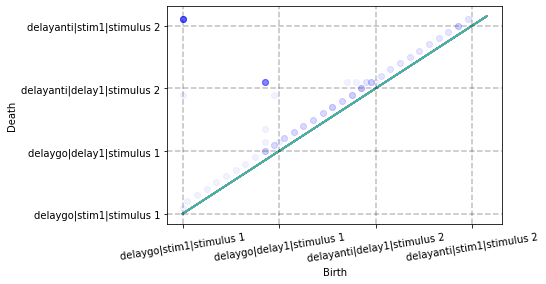

In [20]:
# Plot zigzag persistence diagram
# ax = drawDgm1(ZZ.zz_dgms[0]) # 0-dimensional diagram

for r in dgms:
  ax=drawDgm1(dgms[r], color='b', alpha = 1./n_radii)

labels = get_epoch_labels(ri_set, epoch_list, trial_num)

ax.set_xticks(task_idx)
ax.set_xticklabels(labels, rotation = 9)

ax.set_yticks(task_idx)
ax.set_yticklabels(labels)

for xc in task_idx:
    ax.axvline(x=xc, color='k', linestyle='--', alpha=.25)
    ax.axhline(y=xc, color='k', linestyle='--', alpha=.25)

In [15]:
def drawDgm1(D, boundary=None, epsilon=.5, color=None, alpha = 1):
    """
    Draws simple persistence diagram plot

    :param D:
        a persistence diagram, given as a Nx2 numpy array
    :param boundary:
        Boundary of persistence diagram axes
    :param epsilon:
        The diagram is drawn on [0,boundary]x[0,boundary].
        If boundary not given, then it is determined to be the
        max death time from the input diagram plus epsilon.
    :returns: Figure that includes persistence diagram
    """
    # Separate out the infinite classes if they exist
    includesInfPts = np.inf in D
    if includesInfPts:
        Dinf = D[np.isinf(D[:, 1]), :]
        D = D[np.isfinite(D[:, 1]), :]

    # Get the max birth/death time if it's not already specified
    if not boundary:
        boundary = D.max()+epsilon

    # if fig is None:
    #     fig = plt.figure()
    # ax = fig.gca()
    # Plot the diagonal
    plt.plot([0, boundary], [0, boundary])

    # Plot the diagram points
    if color is None:
        plt.scatter(D[:, 0], D[:, 1], alpha = alpha)
    else:
        plt.scatter(D[:, 0], D[:, 1], c=color, alpha = alpha)

    if includesInfPts:
        plt.scatter(Dinf[:, 0], .98*boundary, marker='s', color='red', alpha = alpha)

        plt.axis([-.01*boundary, boundary, -.01*boundary, boundary])

    plt.ylabel('Death')
    plt.xlabel('Birth')

    return plt

In [25]:
ZZ.filtration.__dict__()

AttributeError: 'dionysus._dionysus.Filtration' object has no attribute '__dict__'